# Exploratory analysis of groundwater monitoring data at a petroleum hydrocarbon contaminated site

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pykml import parser
import matplotlib.tri as tri
%matplotlib inline
sns.set_style("whitegrid")

Read in the well data from an Excel file. Use the well names as the index. Print out the names of the wells.

In [2]:
well_data = pd.read_excel('well_data.xlsx', index_col = [0])

In [3]:
well_names = well_data.index.get_level_values('WELL').unique()
well_names = map(str, well_names)

In [4]:
for name in well_names: print name

MW-2
MW-3
MW-3A
MW-4
MW-5
MW-6
MW-7
MW-8A

MW-10
MW-11

MW-11A
MW-12
MW-13
MW-14
MW-15
MW-16
MW-19
MW-20A
MW-21
MW-22
MW-23
MW-24
MW-25

MW-26
MW-27
MW-28
MW-29
MW-30
MW-31
MW-40


Check the data types for each column in well_data, and convert to numeric as appropriate.

In [5]:
well_data.dtypes

NOTES                        object
CASING_ELEVATION            float64
DATE                 datetime64[ns]
DEPTH_WATER                  object
DEPTH_PRODUCT               float64
PRODUCT_THICKNESS           float64
GW_ELEVATION                 object
dtype: object

In [6]:
well_data['DEPTH_WATER'] = pd.to_numeric(well_data['DEPTH_WATER'], errors = 'coerce')
well_data['GW_ELEVATION'] = pd.to_numeric(well_data['GW_ELEVATION'], errors = 'coerce')



In [7]:
well_data.dtypes

NOTES                        object
CASING_ELEVATION            float64
DATE                 datetime64[ns]
DEPTH_WATER                 float64
DEPTH_PRODUCT               float64
PRODUCT_THICKNESS           float64
GW_ELEVATION                float64
dtype: object

Load well locations from a .kml file 

In [8]:
Y = parser.fromstring(open('Monitoring wells.kml', 'r').read())
name = []
x_coord = []
y_coord = []

for place in Y.Document.Folder.Placemark:
    name.append(str(place.name))
    coords = str(place.Point.coordinates)
    coords = coords.split(',')
    x_coord.append(float(coords[0]))
    y_coord.append(float(coords[1]))




Convert coordinates from lat/long to meters using the monitoring well furthest SE as a datum. At latitude = 43 degrees, the length of a degree of latitude is 111093 m and the length of a degree of longitude is 81514 m.

In [9]:
Xdatum = min(x_coord)
Ydatum = min(y_coord)

x_meters = (np.asarray(x_coord)-Xdatum)*81514.0
y_meters = (np.asarray(y_coord)-Ydatum)*111093.0




Plot the location of the monitoring wells, with distance from the datum (0,0) shown in meters.

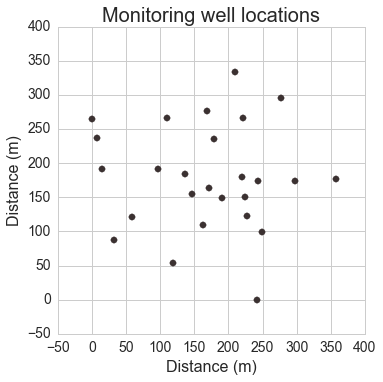

In [10]:
fig, ax = plt.subplots(figsize = (5.5,5.5))
ax.scatter(x_meters,y_meters, color = '#3B3131', s = 40)
plt.title('Monitoring well locations', size = 20)
plt.ylabel('Distance (m)', size = 16)
plt.xlabel('Distance (m)', size = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
sns.set_style()
sns.plt.show()

Add the well location data to the dataframe well_data, so that each row now includes the latitude, longitude, and x and y position in meters.

In [11]:
well_data['x_coord'] = float('NaN')
well_data['y_coord'] = float('NaN')

d = {'Well name': name, 'x_coord': x_coord, 'y_coord':
     y_coord, 'x_meters': x_meters, 'y_meters': y_meters}
well_locs = pd.DataFrame(data = d, index = name)

for well in name:
    if well in well_names:
        well_data.loc[well,'x_coord'] = well_locs.loc[well,'x_coord']
        well_data.loc[well,'y_coord'] = well_locs.loc[well,'y_coord']
        well_data.loc[well,'x_meters'] = well_locs.loc[well,'x_meters']
        well_data.loc[well,'y_meters'] = well_locs.loc[well,'y_meters']
        

Now we can plot the location of wells where free product has been measured. First, let's plot wells where contaminant has been measured within the past year in red, wells where contaminant has been measured longer than a year ago in yellow, and wells where no contaminant has ever been measured in blue.

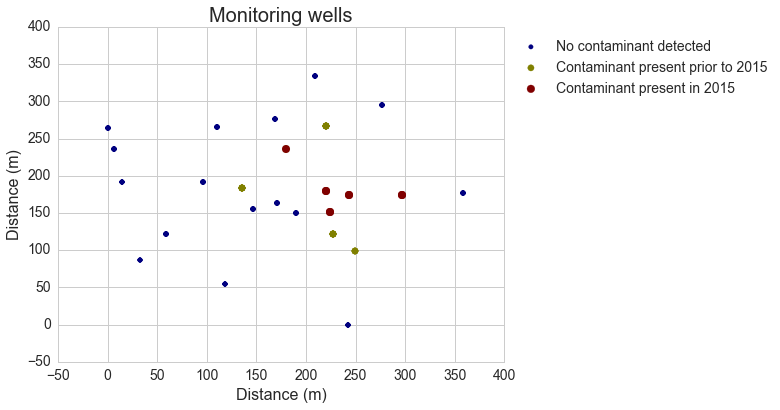

In [12]:
dates = well_data['DATE'].unique()
start_date = np.datetime64('2015-01-01')
mask1 = (well_data['PRODUCT_THICKNESS']>0.0)
well_cont_hist = well_data.loc[mask1]
mask2 = (well_data['DATE'] > start_date)&(well_data['PRODUCT_THICKNESS']>0.0)
well_cont_recent = well_data.loc[mask2]

ax = plt.figure(figsize = (8,6))
plt.scatter(well_data['x_meters'],well_data['y_meters'], color = [0,0,0.5], s = 20)
plt.scatter(well_cont_hist['x_meters'],well_cont_hist['y_meters'], color = [0.5,0.5,0], s = 40)
plt.scatter(well_cont_recent['x_meters'],well_cont_recent['y_meters'], color = [0.5,0,0], s = 60)
plt.legend(('No contaminant detected','Contaminant present prior to 2015',
            'Contaminant present in 2015'),bbox_to_anchor = (1,1),loc = 2, fontsize = 14)
plt.title('Monitoring wells', fontsize = 20)
plt.xlabel('Distance (m)', fontsize = 16)
plt.ylabel('Distance (m)', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

Plot the measured product thickness for the wells where contaminant thickness > 0 has been measured

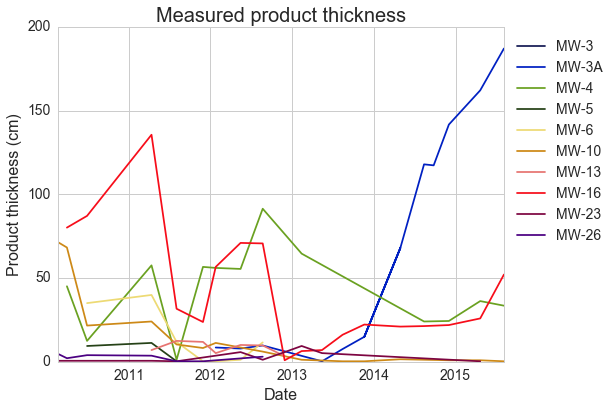

In [13]:
plt.figure(figsize = (8,6))
color_list = ['#151B54','#0020C2','#6AA121','#254117','#EDDA74','#CD8917','#E77471',
              '#F70D1A','#7D0541','#4B0082']
cc = 0
for well in well_cont_hist.index.unique():
    plt.plot(well_cont_hist.ix[well]['DATE'],well_cont_hist.ix[well]['PRODUCT_THICKNESS']*.3048*100,color = color_list[cc])
    cc +=1
plt.legend(well_cont_hist.index.unique(), loc = 2, bbox_to_anchor = (1,1), fontsize = 14)
plt.title('Measured product thickness', fontsize = 20)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Product thickness (cm)', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

Next, let's look at the groundwater levels over time for these same wells.

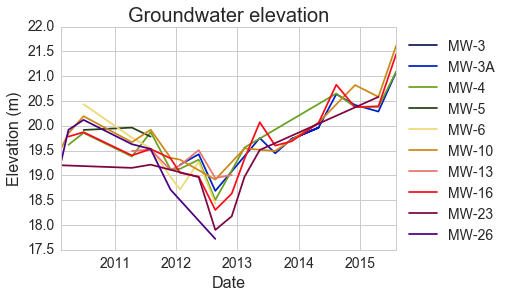

In [14]:
cc = 0
for well in well_cont_hist.index.unique():
    plt.plot(well_cont_hist.ix[well]['DATE'],well_cont_hist.ix[well]['GW_ELEVATION']*.3048,color = color_list[cc])
    cc +=1
plt.legend(well_cont_hist.index.unique(), loc = 2, bbox_to_anchor = (1,1), fontsize = 14)
plt.title('Groundwater elevation', fontsize = 20)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Elevation (m)', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

We can also make a map showing the variation in water levels across the site for a given date.

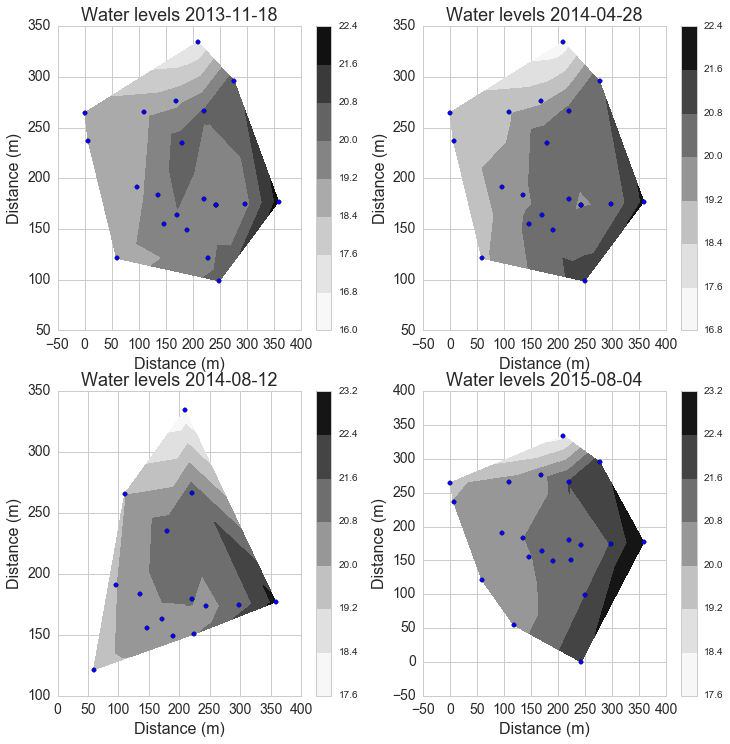

In [51]:
start_date = [np.datetime64('2013-11-18'),np.datetime64('2014-04-28'),
              np.datetime64('2014-08-12'),np.datetime64('2015-08-04')]
end_date = [np.datetime64('2013-11-20'),np.datetime64('2014-04-30'),
            np.datetime64('2014-08-14'),np.datetime64('2015-08-06')]

plt.figure(figsize = (12,12) )
for N in range(0,4):
    mask = (well_data['DATE'] > start_date[N])&(well_data['DATE'] < end_date[N])
    water_levels = well_data.loc[mask]
    water_levels = water_levels.dropna(subset=['x_meters','y_meters','GW_ELEVATION'])

    x = water_levels['x_meters'].values
    y = water_levels['y_meters'].values
    z = water_levels['GW_ELEVATION'].values*0.3048
    T = tri.Triangulation(x, y)

    plt.subplot(2,2,N+1)
    plt.tricontourf(T,z)
    plt.colorbar()
    plt.scatter(x,y)
    plt.title('Water levels %s' %(str(start_date[N])), fontsize = 18)
    plt.xlabel('Distance (m)', fontsize = 16)
    plt.ylabel('Distance (m)', fontsize = 16)
    plt.yticks(fontsize = 14)
    plt.xticks(fontsize = 14)


plt.show()
